# C.1.1 Blocks to points Ordinary Kriging

## Table of Contents:

1. Read block data,
2. Detect and remove outliers,
3. Create semivariogram model,
4. Read point data canvas,
5. Build map of interpolated values,
6. Show map of interpolated values with choropleth map of the breast cancer rates.


## Introduction

This tutorial is based on the question of user *@ikey* from *Discord* channel of the package (02/04/2021). Thank you *@ikey* for your engagement!

In short:

> Are we able to perform Semivariogram Regularization and Poisson Kriging if our point support represents only points without any values?

**No, it's not possible**. But there is a hack that we can use - we can interpolate missing values from areal centroids with Ordinary and Simple Kriging just like we do with *regular points*. Why is it not possible with unknown points?

The idea behind semivariogram regularization of areal aggregates is to use semivariogram of point support. Point support must reflect an ongoing process. For example, in the case of epidemiology:

1. We have areal counts of infections divided by POPULATION over some areas.
2. We take POPULATION blocks (points) with a number of inhabitants per block and use those as support for our map. Thus we transform the choropleth map into the point map, and only to the points where someone is living ==> someone may be infected. We skip large parts of the map where the risk of infection is not present because no one is living there.
3. We finally obtain the population-at-risk map of points or smoothed choropleth map of infection risk without large visual bias where large/small areas seem to be more important.

This works when we have specific **counts over area divided by another parameter** (time, population, probability, volume, etc.). In this scenario, we can find a function that links our areal counts with those underlying variables and/or processes. Without support values, we are not able to perform semivariogram regularization.

What we want to achieve may be done with Ordinary Kriging (because our points are unknown), and semivariogram regularization is not required (and not possible without any values).

In summary, we will learn how to:

- transform areal data into points,
- detect and remove outliers from data,
- create an interpolated map from unknown points,
- visualize and save the created map.

We use:

- for point canvas: `samples/point_data/shapefile/regular_grid_points.shp`,
- for areal centroids: Breast cancer rates data is stored in the shapefile  `samples/regularization/cancer_data.gpkg`.

This tutorial requires understanding concepts presented in **Semivariogram Estimation** and **Variogram Point Cloud** tutorials along with **Ordinary and Simple Kriging** notebook and (optionally) **Semivariogram Regularization** tutorial.

## Import packages

In [1]:
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

from pyinterpolate import Blocks, VariogramCloud, TheoreticalVariogram, kriging

## 1) Read areal data

The block data represents the breast cancer rates in the Northeastern part of the United States. Rate is the number of new cases divided by the population in a county, and this fraction is multiplied by a constant factor of 100,000.

We read data from `geopackage` and use only `rate`, `centroid.x`, and `centroid.y` columns.

In [2]:
# Read and prepare data

DATASET = 'samples/regularization/cancer_data.gpkg'
POLYGON_LAYER = 'areas'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'
MAX_RANGE = 400000
STEP_SIZE = 40000

AREAL_INPUT = Blocks()
AREAL_INPUT.from_file(DATASET, value_col=POLYGON_VALUE, index_col=POLYGON_ID, layer_name=POLYGON_LAYER)

AREAL_INPUT.data.head()

ERROR 1: PROJ: proj_create_from_database: Open of /home/szymon/mambaforge/envs/mpyint/share/proj failed


,FIPS,geometry,rate,centroid_x,centroid_y
0,25019,"MULTIPOLYGON (((2115688.816 556471.240, 211569...",192.2,2.132630e+06,557971.155949
1,36121,"POLYGON ((1419423.430 564830.379, 1419729.721 ...",166.8,1.442153e+06,550673.935704
2,33001,"MULTIPOLYGON (((1937530.728 779787.978, 193751...",157.4,1.958207e+06,766008.383446
3,25007,"MULTIPOLYGON (((2074073.532 539159.504, 207411...",156.7,2.082188e+06,556830.822367
4,25001,"MULTIPOLYGON (((2095343.207 637424.961, 209528...",155.3,2.100747e+06,600235.845891


In [3]:
areal_centroids = AREAL_INPUT.data[['centroid_x', 'centroid_y', 'rate']].values
areal_centroids[0]

array([2.13262960e+06, 5.57971156e+05, 1.92200000e+02])

## 2) Detect and remove outliers

We check and clean data before the semivariogram fitting and the Ordinary Kriging interpolation. Variogram Point Cloud is the best way to analyze data and detect outliers. We inspect and compare different lags and step sizes and their respective point clouds. Then we will create multiple variograms and Kriging models.

In [4]:
# Create analysis parameters

maximum_range = 300000

number_of_lags = [4, 8, 16]
step_sizes = [maximum_range / x for x in number_of_lags]

variogram_clouds = []

for step_size in step_sizes:
    vc = VariogramCloud(input_array=areal_centroids, step_size=step_size, max_range=maximum_range+step_size)
    variogram_clouds.append(vc)

Lags per area: 4


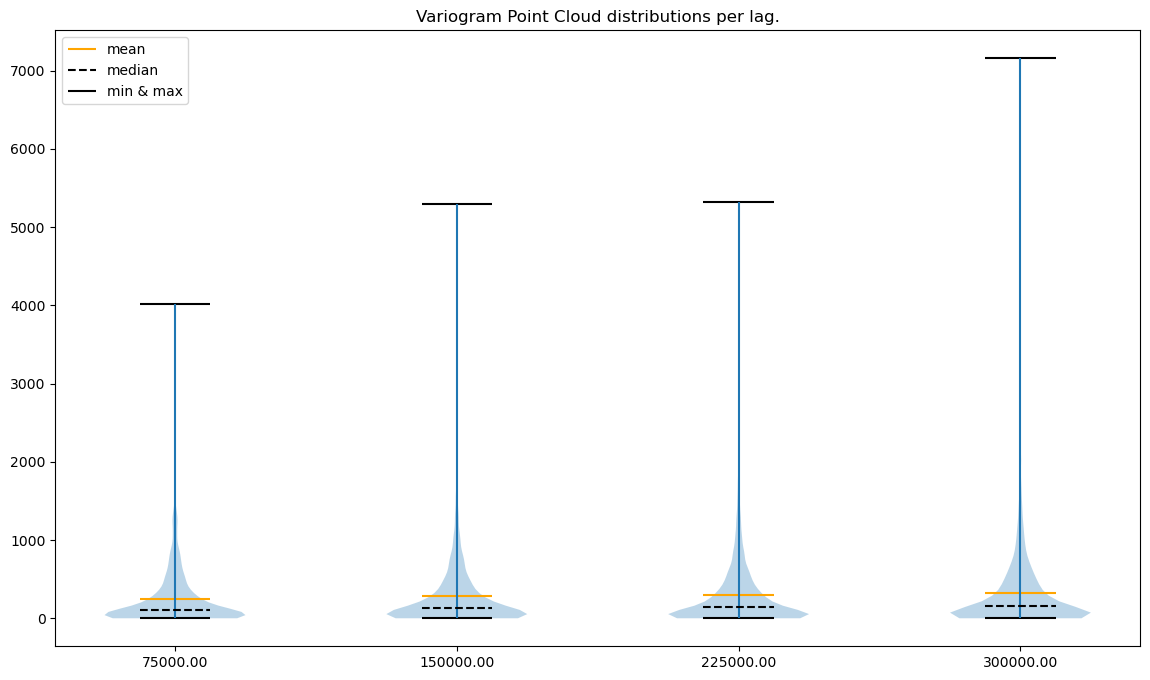


###########

Lags per area: 8


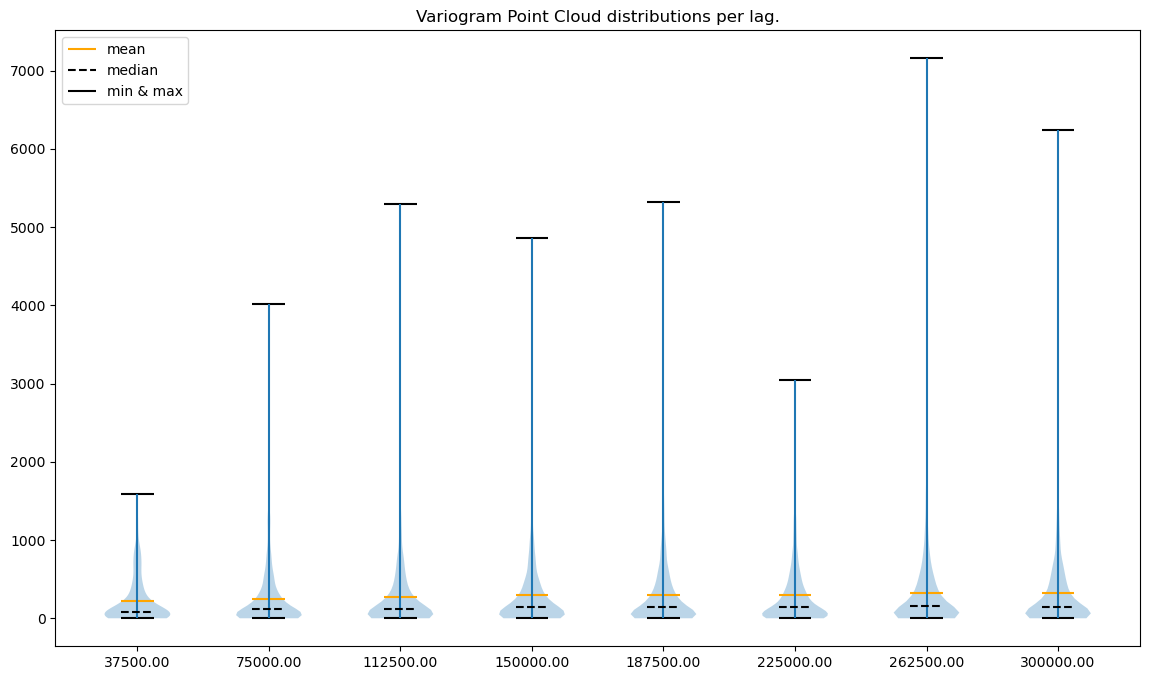


###########

Lags per area: 16


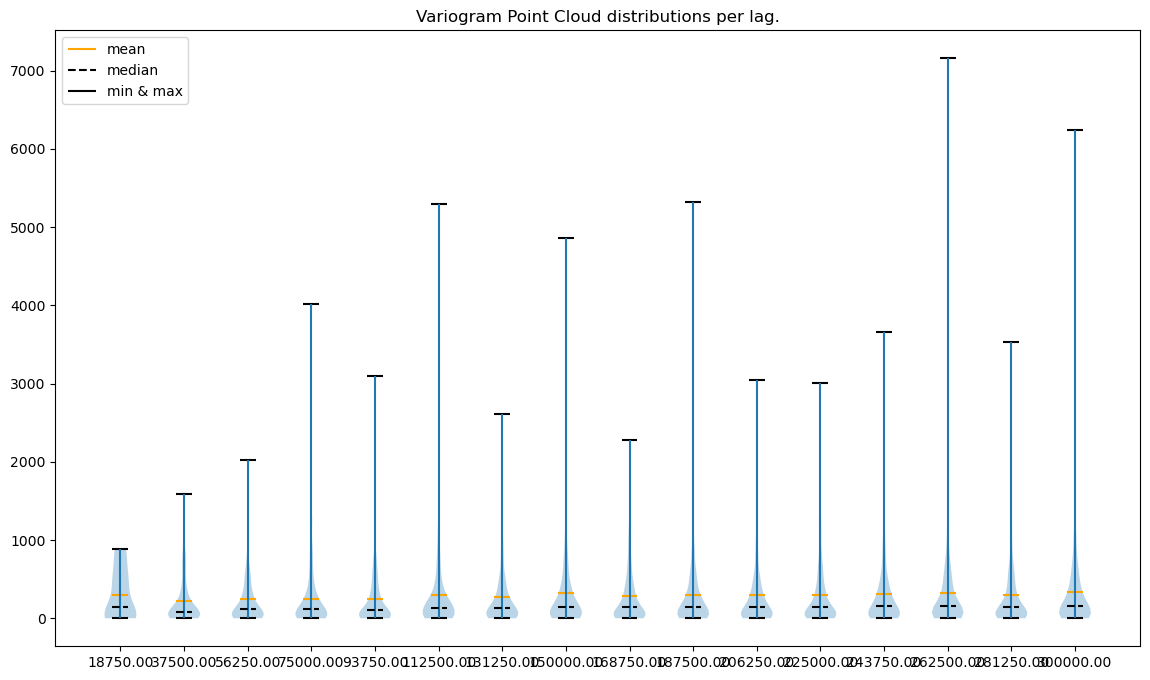


###########


In [5]:
for vc in variogram_clouds:
    print(f'Lags per area: {len(vc.lags)}')
    print('')
    vc.plot('violin')
    print('\n###########\n')

What does a fast check tell us?

- point to point errors per lag are skewed toward positive values (the mean is always greater than the median),
- less lags == less variability,
- variability in the last case (32 lags) seems to be too high,
- variability in the first case (4 lags) seems to be too small,
- there are extreme semivariance values, and the largest extremities are present for the most distant lags.

What can we do?

- remove outliers (extremely high semivariances) per each lag,
- use a small number of neighbors and a range close to 200,000 to avoid unnecessary computations.

In [6]:
# Now remove outliers from each lag

_ = [vc.remove_outliers(method='iqr', iqr_lower_limit=3, iqr_upper_limit=1.5, inplace=True) for vc in variogram_clouds]

Lags per area: 4


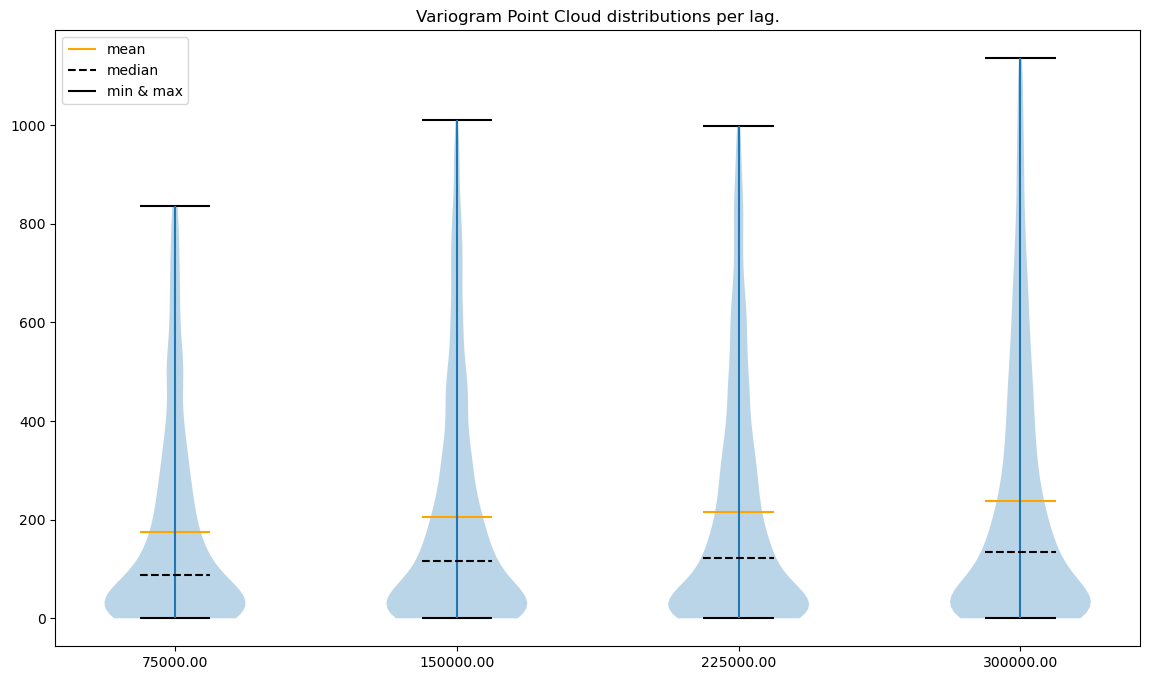


###########

Lags per area: 8


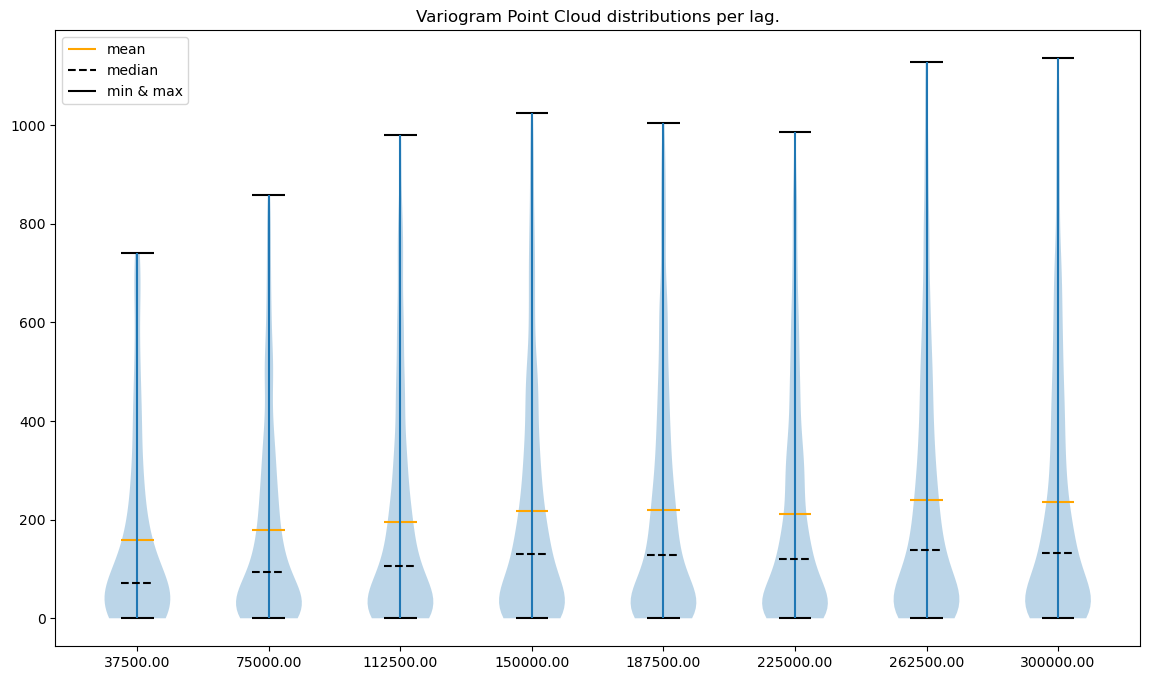


###########

Lags per area: 16


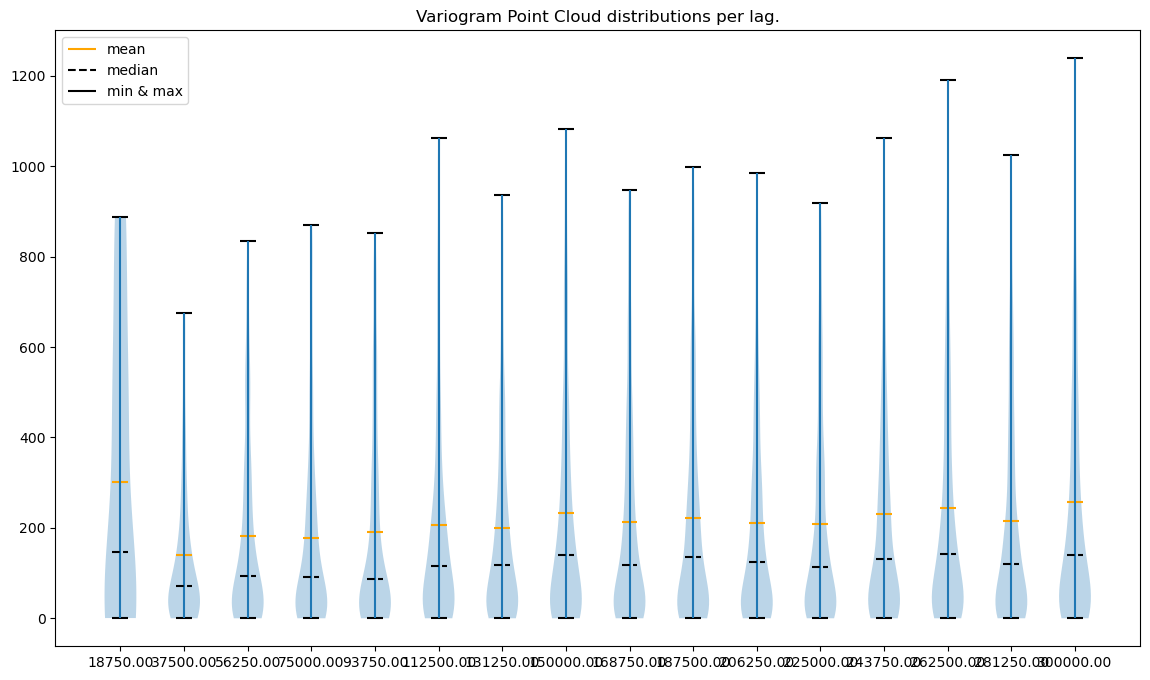


###########


In [7]:
# And show data without outliers

for vc in variogram_clouds:
    print(f'Lags per area: {len(vc.lags)}')
    print('')
    vc.plot('violin')
    print('\n###########\n')

If we compare the **y axis** before and after removing outliers, we may see that values are now smaller and densely populated. After outlier removal, we see also that 32 lags are too much, and especially for the first lag, it generates too much noise. We can expect that model based on this division will work poorly.

## 3. Create a theoretical semivariogram model

Semivariogram may be fitted manually or automatically. In this case, we fit it automatically - we test multiple models, and it's easier to use the `autofit()` method of the `TheoreticalVariogram` object. We didn't force any model to see how different results we would get.

In [8]:
theoretical_semivariograms = []

for idx, vc in enumerate(variogram_clouds):
    
    print(f'Semivariance calculated for {vc.lags} lags.')
    print('')
    # Calculate experimental model
    exp_model = vc.calculate_experimental_variogram()
    
    # Assign experimental model and data to TheoreticalSemivariogram

    theo_semi = TheoreticalVariogram()
    theo_semi.autofit(experimental_variogram=exp_model, nugget=0, direction=None)
    theoretical_semivariograms.append(theo_semi)
    print('')
    print('Model parameters:')
    print('Model type:', theo_semi.name)
    print('Nugget:', theo_semi.nugget)
    print('Sill:', theo_semi.sill)
    print('Range:', theo_semi.rang)
    print('Model error:', theo_semi.rmse)
    print('')
    print('#####')

Semivariance calculated for [ 75000. 150000. 225000. 300000.] lags.


Model parameters:
Model type: spherical
Nugget: 0
Sill: 104.18060667237297
Range: 118000.0
Model error: 7.462726772043129

#####
Semivariance calculated for [ 37500.  75000. 112500. 150000. 187500. 225000. 262500. 300000.] lags.


Model parameters:
Model type: spherical
Nugget: 0
Sill: 109.59322531046718
Range: 70000.0
Model error: 9.709346473449811

#####
Semivariance calculated for [ 18750.  37500.  56250.  75000.  93750. 112500. 131250. 150000. 168750.
 187500. 206250. 225000. 243750. 262500. 281250. 300000.] lags.


Model parameters:
Model type: spherical
Nugget: 0
Sill: 111.06413642423938
Range: 30000.0
Model error: 21.29533062806228

#####


Each case has a different model type, a different sill, and a different range! How do we choose the model parameters appropriately in this scenario? Error rises with the number of lags but is it a good indicator of the semivariogram fit? No, and we should be careful when choosing variograms with a few lags instead of variograms with multiple lags. We may miss some spatial patterns that will be averaged with a smaller number of lags. The 8-lag variogram seems to be the best because RMSE is the lowest. On the other hand, 32-lags variograms work poorly!

## 4. Read point data canvas

Our variogram model is ready to load the point file as the **GeoDataFrame** object, which stores the geometry column and data features as tables.

In [9]:
points = 'samples/point_data/shapefile/regular_grid_points.shp'  # file with grid for analysis
gdf_pts = gpd.read_file(points)
gdf_pts.set_index('id', inplace=True)
gdf_pts['x'] = gdf_pts.geometry.x
gdf_pts['y'] = gdf_pts.geometry.y
gdf_pts.head()

,geometry,x,y
id,,,
81.0,POINT (1277277.671 441124.507),1.277278e+06,441124.5068
82.0,POINT (1277277.671 431124.507),1.277278e+06,431124.5068
83.0,POINT (1277277.671 421124.507),1.277278e+06,421124.5068
84.0,POINT (1277277.671 411124.507),1.277278e+06,411124.5068
85.0,POINT (1277277.671 401124.507),1.277278e+06,401124.5068


## 5. Build a map of interpolated values

We can model all values in a batch. If we set the `number_of_workers` parameter to `-1` or a positive integer, then the algorithm will use parallel processing functions to speed up calculations.

Based on the learning from a semivariogram modeling step, we will set a number of neighboring areas to 8 and range to 200000. We will append interpolated values and errors to an existing data frame and plot them to compare results.

In [10]:
preds_cols = []
errs_cols = []

for semi_model in theoretical_semivariograms:
    kriged = kriging(observations=areal_centroids,
                     theoretical_model=semi_model,
                     points=gdf_pts[['x', 'y']].values,
                     neighbors_range=200000,
                     no_neighbors=8,
                     number_of_workers=1,
                     use_all_neighbors_in_range=True)
    
    # Interpolate missing values and uncertainty
    pred_col_name = 'p ' + semi_model.name[:3] + ' ' + str(len(semi_model.lags))
    uncertainty_col_name = 'e ' + semi_model.name[:3] + ' ' + str(len(semi_model.lags))
    gdf_pts[pred_col_name] = kriged[:, 0]
    gdf_pts[uncertainty_col_name] = kriged[:, 1]
    preds_cols.append(pred_col_name)
    errs_cols.append(uncertainty_col_name)

100%|██████████| 5419/5419 [00:04<00:00, 1170.71it/s]


In [11]:
gdf_pts.head()

,geometry,x,y,p sph 4,e sph 4,p sph 8,e sph 8,p sph 16,e sph 16
id,,,,,,,,,
81.0,POINT (1277277.671 441124.507),1.277278e+06,441124.5068,132.133667,65.848568,133.061501,100.081621,131.969565,115.893012
82.0,POINT (1277277.671 431124.507),1.277278e+06,431124.5068,130.583635,64.566536,131.102959,100.171994,130.604348,115.893012
83.0,POINT (1277277.671 421124.507),1.277278e+06,421124.5068,129.607074,63.776407,130.397073,99.884160,130.604348,115.893012
84.0,POINT (1277277.671 411124.507),1.277278e+06,411124.5068,128.854301,63.223374,130.168520,99.475313,130.604348,115.893012
85.0,POINT (1277277.671 401124.507),1.277278e+06,401124.5068,128.549723,62.707759,130.652012,98.828762,130.860000,115.506702


This is the somewhat complicated function in which we interpolate missing values as new columns of **GeoDataFrame**. *Uncertainty* is assigned to interpolated results for further analysis.

Now we can save our **GeoDataFrame** as a shapefile.

In [12]:
# Save interpolation results

gdf_pts.to_file('output/interpolation_results_areal_to_point.shp')

Now we will check the results directly in the notebook.

## 6. Show a map of interpolated values with a choropleth map of the breast cancer rates

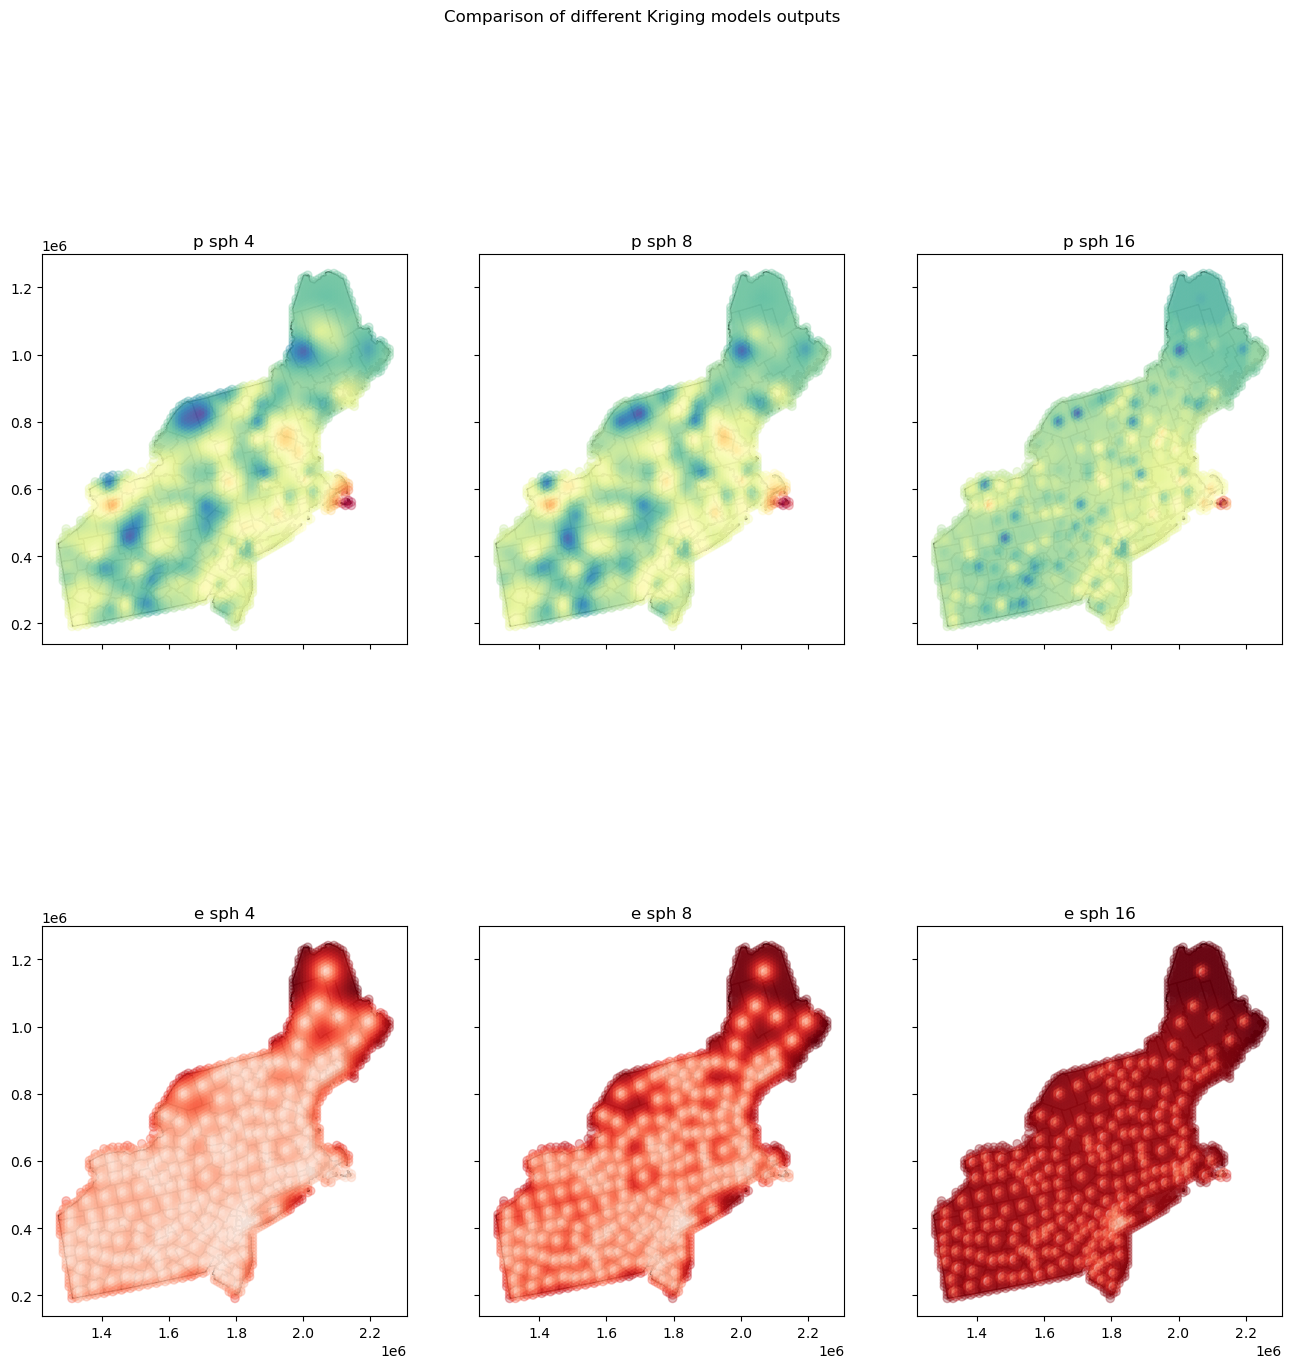

In [13]:
# Now compare results to choropleth maps
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 16), sharex='all', sharey='all')

base1 = AREAL_INPUT.data.plot(ax=axes[0, 0], legend=True, edgecolor='black', color='white')
base2 = AREAL_INPUT.data.plot(ax=axes[0, 1], legend=True, edgecolor='black', color='white')
base3 = AREAL_INPUT.data.plot(ax=axes[0, 2], legend=True, edgecolor='black', color='white')
base4 = AREAL_INPUT.data.plot(ax=axes[1, 0], legend=True, edgecolor='black', color='white')
base5 = AREAL_INPUT.data.plot(ax=axes[1, 1], legend=True, edgecolor='black', color='white')
base6 = AREAL_INPUT.data.plot(ax=axes[1, 2], legend=True, edgecolor='black', color='white')

gdf_pts.plot(ax=base1, column=preds_cols[0], cmap='Spectral_r', alpha=0.3)
gdf_pts.plot(ax=base2, column=preds_cols[1], cmap='Spectral_r', alpha=0.3)
gdf_pts.plot(ax=base3, column=preds_cols[2], cmap='Spectral_r', alpha=0.3)
gdf_pts.plot(ax=base4, column=errs_cols[0], cmap='Reds', alpha=0.3)
gdf_pts.plot(ax=base5, column=errs_cols[1], cmap='Reds', alpha=0.3)
gdf_pts.plot(ax=base6, column=errs_cols[2], cmap='Reds', alpha=0.3)

axes[0, 0].set_title(preds_cols[0])
axes[0, 1].set_title(preds_cols[1])
axes[0, 2].set_title(preds_cols[2])
axes[1, 0].set_title(errs_cols[0])
axes[1, 1].set_title(errs_cols[1])
axes[1, 2].set_title(errs_cols[2])

plt.suptitle('Comparison of different Kriging models outputs')
plt.show()

Visual inspection shows that:

> The circular model and the exponential model have created the smoothest results. An interesting pattern emerges on uncertainty maps. The variance errors are smoother on the first map (the circular model). The middle map produces a higher variance in output, but it still works as a filter. The last model doesn't perform well, has too strict distance constraints, and the final outcome is not smooth. Sharply increasing variance errors on the uncertainty map of the cubic model tell us that maybe we have chosen the wrong model - we are not able to retrieve meaningful information from it.

Are absolute errors between maps large or not? Let's check it in the last step:

In [14]:
for pcol1 in preds_cols:
    print('Column:', pcol1)
    for pcol2 in preds_cols:
        if pcol1 == pcol2:
            pass
        else:
            mad = gdf_pts[pcol1] - gdf_pts[pcol2]
            mad = np.abs(np.mean(mad))
            print(f'Mean Absolute Difference with {pcol2} is {mad:.4f}')
    print('')

Column: p sph 4
Mean Absolute Difference with p sph 8 is 0.2395
Mean Absolute Difference with p sph 16 is 0.6387

Column: p sph 8
Mean Absolute Difference with p sph 4 is 0.2395
Mean Absolute Difference with p sph 16 is 0.3993

Column: p sph 16
Mean Absolute Difference with p sph 4 is 0.6387
Mean Absolute Difference with p sph 8 is 0.3993


That differences are tiny, so we shouldn't throw away one model after another. Semivariogram models are comparable. I prefer the **8-lag** theoretical variogram with an exponential model, and it has the best bias-to-variance ratio and a low RMSE error.

---

## Changelog

| Date       | Change description                                                                                                                                                      | Author |
|------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------|
| 2023-08-23 | The tutorial was refreshed and set along with the 0.5.0 version of the package                                                                                    | @SimonMolinsky |
| 2023-04-15 | Tutorial updated for the 0.4.1 version of the package                                                                                                                   | @SimonMolinsky |
| 2022-11-05 | Tutorial updated for the 0.3.5 version of the package                                                                                                                   | @SimonMolinsky |
| 2022-10-21 | Tutorial updated for the 0.3.4 version of the package                                                                                                                   | @SimonMolinsky |
| 2022-08-23 | Tutorial updated for the 0.3.0 version of the package                                                                                                                   | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class                                                   | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                                                                                 | @SimonMolinsky |
| 2021-12-06 | Behavior of `prepare_kriging_data()` function has changed                                                                                                               | @SimonMolinsky |
| 2021-10-13 | Refactored TheoreticalSemivariogram (name change of class attribute) and refactored `calc_semivariance_from_pt_cloud()` functions to protect calculations from `NaN's`. | @ethmtrgt & @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class                                                                                                                               | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data.                                                                                     | @SimonMolinsky |